In [194]:
%matplotlib inline

import geopandas
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.ops import unary_union
from shapely.ops import intersection

from copy import deepcopy
import math

ImportError: cannot import name 'intersection' from 'shapely.ops' (/home/osullid3/anaconda3/envs/tiling/lib/python3.8/site-packages/shapely/ops.py)

In [205]:
class Weave_Unit():
    
    def __init__(self, wh=1, sh=1.5, wv=2, sv=2, labelsh=[1], labelsv=[2]):
        self.wh = wh
        self.sh = sh
        self.wv = wv
        self.sv = sv
        self.labelsh = labelsh
        self.labelsv = labelsv
        self.shapes, self.labels = self.get_shapes()
        self.dx, self.dy = self.get_vector()
        
    def get_shapes(self):
        polys = []
        labels = []
        
        lh = 2 * self.sv - self.wv
        lv = 2 * self.sh - self.wh
        
        base_ph = Polygon([(-lh/2, -self.wh/2), (lh/2, -self.wh/2), (lh/2, self.wh/2), (-lh/2, self.wh/2)])
        base_pv = Polygon([(-self.wv/2, -lv/2), (-self.wv/2, lv/2), (self.wv/2, lv/2), (self.wv/2, -lv/2)])
        
        nh = len(self.labelsh)
        nv = len(self.labelsv)
        
        for row in range(-1, len(self.labelsh) * 2 + 1):
            for col in range(-1, len(self.labelsv) * 2 + 1):
                poly = deepcopy(base_ph) if (col + row) % 2 == 0 else deepcopy(base_pv)
                polys.append(translate(poly, xoff = col * self.sv, yoff = row * self.sh))
                label = self.labelsh[row % nh] if (col + row) % 2 == 0 else self.labelsv[col % nv]
                labels.append(label)
        return (polys, labels)
        
    def get_vector(self):
        return (2 * len(self.labelsv) * self.sv,
                2 * len(self.labelsh) * self.sh)
    
    def get_tile(self):
        bb = box(0, 0, self.dx, self.dy)
        c_bb = bb.centroid
        c_w = unary_union(self.shapes).centroid
        bb = translate(bb, c_w.x - c_bb.x, c_w.y - c_bb.y)
        shapes = []
        labels = []
        for s, label in zip(w.shapes, w.labels):
            if s.intersects(bb):
                shapes.append(s.intersection(bb))
                labels.append(label)
        return {"shapes": shapes, "labels": labels}
    

In [206]:
w = Weave_Unit(wh = 1, sh = 1.5, wv = 0.9, sv = 1.25, labelsh = [1, 2], labelsv = [5, 6, 7])

In [207]:
tile = w.get_tile()

In [208]:
gdf = geopandas.GeoDataFrame(data = {"label": tile["labels"]}, geometry = geopandas.GeoSeries(tile["shapes"]))

<AxesSubplot:>

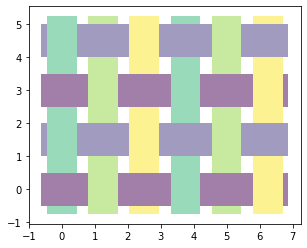

In [209]:
gdf.plot(column = "label", alpha = 0.5)

In [210]:
gdf.to_file("tile.geojson", driver = "GeoJSON")

## Possible tiling code

In [ ]:
def tile(w, minx = -30, miny = -30, maxx = 30, maxy = 30, rotation = 0):
    tiling_w = maxx - minx
    tiling_h = maxy - miny
    bb = unary_union(w.shapes).bounds
    width = bb[2] - bb[0]
    height = bb[3] - bb[1]
    repeats_h = math.ceil(tiling_w / width)
    repeats_v = math.ceil(tiling_h / height)
    total_w = repeats_h * width
    total_h = repeats_v * height
    origin_offset_x = (minx - (total_w - tiling_w) / 2) - bb[0]
    origin_offset_y = (miny - (total_h - tiling_h) / 2) - bb[1]
    template = []
    for s in deepcopy(w.shapes):
        template.append(translate(s, origin_offset_x, origin_offset_y))
    shapes = []
    for col in range(repeats_h):
        for row in range(repeats_v):
            for t in template:
                shapes.append(translate(deepcopy(t), w.dx * col, w.dy * row))
    labels = w.labels * (repeats_h * repeats_v)
    return geopandas.GeoDataFrame(data = {"label": labels}, geometry = geopandas.GeoSeries(shapes))

In [180]:
t = tile(w)

<AxesSubplot:>

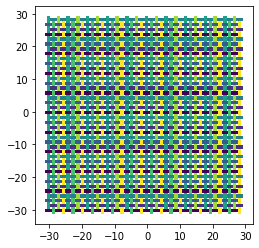

In [181]:
t.plot(column = "label")

In [178]:
t.to_file("weave.gpkg", driver = "GPKG")

In [48]:
gdf.geometry

0    POLYGON ((-1.50000 -0.50000, 1.50000 -0.50000,...
1    POLYGON ((0.50000 -0.50000, 3.50000 -0.50000, ...
2    POLYGON ((-0.50000 0.50000, 2.50000 0.50000, 2...
3    POLYGON ((-0.50000 0.50000, 2.50000 0.50000, 2...
Name: geometry, dtype: geometry